# testing_power_normalizations
This notebook is a testing ground for creating and normalizing power spectra, and cross-checking between different methods (i.e., light curve in units of counts/bin vs light curve in units of counts/second). Trying things out for stingray/tests/test_crossspectrum.py.

In [1]:
import numpy as np
from scipy import fftpack
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import scipy
scipy.__version__

'1.2.1'

In [3]:
np.__version__

'1.11.3'

### Setting things up
Using the same seed as in stingray/tests/test_crossspectrum.py (henceforth "the stingray test") and the same function and parameters for `counts1`.

In [4]:
np.random.seed(20160528)
tstart = 0.0
tend = 1.0
dt = 0.0001
n_bins = int(tend/dt)
time = np.arange(tstart + 0.5 * dt, tend + 0.5 * dt, dt)
assert n_bins == int(time.shape[0])
counts1 = np.random.poisson(0.01, size=time.shape[0])  # exact same function as in test_crossspectrum.py in stingray
lc_1 = counts1/dt  # puts it in units of counts/second
idx_nyq = int(n_bins/2)+1  # index of the nyquist frequency
freqs = np.abs(fftpack.fftfreq(n_bins, d=dt)[0:idx_nyq])  # nyquist freq is neg in scipy; want it to be positive for plotting purposes
meanrate1 = np.mean(lc_1)  # actual mean of the light curve
realrate1 = 100.  # expected mean of the light curve
print(meanrate1, realrate1)

108.0 100.0


### Computing the power of the counts/second light curve 

In [5]:
lc_sub_mean_1 = lc_1 - meanrate1  # removes the DC component at f = 0 Hz
fft_1 = fftpack.fft(lc_sub_mean_1)
powersquare1 = np.square(fft_1)[0:idx_nyq]  
print("Square:", powersquare1[1:5])
poweramp1 = (np.absolute(fft_1)**2)[0:idx_nyq] # amplitude or magnitude (which is a real number)
powerreal1 = np.real(fft_1**2)[0:idx_nyq]  # real component of the square fft
powerconj1 = np.multiply(fft_1, np.conj(fft_1))[0:idx_nyq].real
print("Amp:", poweramp1[1:5])
print("Real:", powerreal1[1:5])
print("Conj:", powerconj1[1:5])
print(np.allclose(poweramp1, powerconj1))

Square: [ -2.73803744e+09 -5.21067173e+09j   7.54949222e+09 +9.62516455e+09j
  -1.66301081e+09 +6.09808425e+08j  -2.96717473e+09 +1.08323931e+09j]
Amp: [  5.88625083e+09   1.22326868e+10   1.77129085e+09   3.15872336e+09]
Real: [ -2.73803744e+09   7.54949222e+09  -1.66301081e+09  -2.96717473e+09]
Conj: [  5.88625083e+09   1.22326868e+10   1.77129085e+09   3.15872336e+09]
True


## WEIRD.
Computing the power spectrum four different ways: squaring the fft, taking the real of the squared fft, taking the amplitude (or magnitude) of the squared fft, and multiplying fft by its complext conjugate. `powerconj1` is the 'true' way to do it, but I expected all four ways to give the same result. `powerconj1==poweramp1` and `powersquare1==powerreal1`, and `powersquare1` and `powerreal1` are giving the wrong answer. We can test this by normalizing them and seeing if they produce approximately the expected Poisson noise level.

In [6]:
abs_noise1 = 2. * realrate1

print("From the complex conjugate:")
absconj1 = powerconj1 * 2.0 * dt / float(n_bins)
print(np.mean(absconj1), abs_noise1)
print(np.isclose(np.mean(absconj1), abs_noise1, atol=30))

print("From the real component of the fft^2:")
absreal1 = powerreal1 * 2.0 * dt / float(n_bins)
print(np.mean(absreal1), abs_noise1)
print(np.isclose(np.mean(absreal1), abs_noise1, atol=30))

From the complex conjugate:
217.623675265 200.0
True
From the real component of the fft^2:
1.66686662667 200.0
False


We see that the 'conj' one is right, and the 'real' one is wrong, as expected. Stingray uses 'conj' in crossspectrum.py, but the answers in the stingray test suite look like that of 'real'. Why???

Plotting, in case visual helps. Red line is the expected poisson noise level, blue is normalized from 'conj' power spectrum.

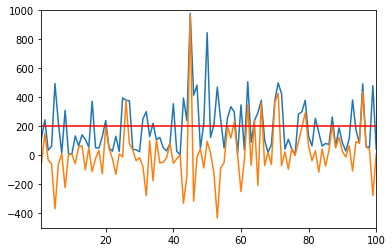

In [7]:
plt.plot(freqs, absconj1)
plt.axhline(y=abs_noise1, xmin=freqs[0], xmax=freqs[-1], color='r')
plt.xlim(freqs[1], 100)
plt.ylim(-500, 1000)
plt.show()
plt.close()

Now computing the power spectrum of the light curve in units of counts/bin. This has a different absolute rms-squared normalization for the power spectrum, since the input light curve is in different units. This was my initial reason for making this testing notebook. Comparing with the same expected Poisson noise level, because we're using the same normalization, just getting there a different way.

In [8]:
ctsfft_1 = fftpack.fft(counts1, axis=0)
ctspowconj1 = np.multiply(ctsfft_1, np.conj(ctsfft_1))[0:idx_nyq].real

nphots1 = np.sum(counts1)
meancounts1 = np.mean(counts1)
log_nphots1 = np.log(nphots1)
actual_nphots = np.float64(np.sqrt(np.exp(log_nphots1 + log_nphots1)))
actual_mean = np.sqrt(meancounts1 * meancounts1)
actual_rate = np.sqrt(meanrate1 * meanrate1)

cts_absconj1 = ctspowconj1 * 2. * actual_rate / actual_nphots

print(np.mean(cts_absconj1), abs_noise1)
print(np.isclose(np.mean(cts_absconj1), abs_noise1, atol=30))

222.288342332 200.0
True


Plotting again. Can see that the normalization gives the expected Poisson noise level.

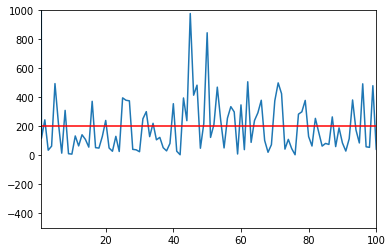

In [9]:
plt.plot(freqs, cts_absconj1)
plt.axhline(y=abs_noise1, xmin=freqs[0], xmax=freqs[-1], color='r')
plt.xlim(freqs[1], 100)
plt.ylim(-500, 1000)
plt.show()
plt.close()

Its value looks more like that of fractional rms-squared normalized power. Speaking of, let's check with other normalizations for 'conj' and 'real'. Using the counts/sec light curve.

In [13]:
frac_noise1 = 2.0 / realrate1

fracconj1 = powerconj1 * 2.0 * dt / float(n_bins) / (meanrate1**2)
print(np.mean(fracconj1), frac_noise1)
print(np.isclose(np.mean(fracconj1), frac_noise1, atol=0.0015))

From the complex conjugate:
(0.0186577225021+0j) 0.02
True
From the real component of the fft^2:
0.000142906946731 0.02
True


In [14]:
leahy_noise = 2.
leahyconj1 = powerconj1 * 2.0 * dt / float(n_bins) / mean_1
print(np.mean(leahyconj1), leahy_noise)
print(np.isclose(np.mean(leahyconj1), leahy_noise, atol=0.05))

From the complex conjugate:
(2.01503403023+0j) 2.0
True
From the real component of the fft^2:
0.015433950247 2.0
False


From the executed stingray tests, the value it spits out in abs rms-squared norm is what I get for using the real of the fft squared. It *should* spit out what I get for the complex conjugate power that's been abs rms-squared norm'd, which as we've tested here, has the correct equation.

But, it doesn't explain why it passes the leahy and frac tests that also get executed.

Below is for writing a test for lc_2 and normalizing the cross spectrum between the two of them, but we need to get the power spectrum of lc_1 working first.

In [12]:
# np.random.seed(20160528)  # same seed as before
# counts2 = np.random.negative_binomial(1, 0.09, size=time.shape[0])  # copied same function as in stingryay/tests/test_crossspectrum.py
# lc_2 = counts2/dt
# mean_2 = np.mean(lc_2)
# realrate_2 = 1.0e5
# print(mean_2, realrate_2)
# fft_2 = fftpack.fft(lc_2-mean_2, axis=0)
# cross = fft_1 * np.conj(fft_2)
# cross = cross[0:len_pos]
# power_2 = np.absolute(fft_2)**2

In [13]:
# abs_2 = power_2 * 2.0 * dt / float(time.shape[0])
# abs_noise2 = 2. * real_2
# print(np.mean(abs_2), abs_noise2)
# frac_2 = power_2 * 2.0 * dt / float(time.shape[0]) / (mean_2**2)
# frac_noise2 = 2.0 / real_2
# print(np.mean(frac_2), frac_noise2)

In [14]:
# leahy_2 = power_2 * 2.0 * dt / float(time.shape[0]) / mean_2
# leahy_noise = 2.
# print(np.mean(leahy_2), leahy_noise)

In [15]:
# abs_cross = cross * 2.0 * dt / float(time.shape[0])
# abs_noisec = 2. * np.sqrt(mean_1*mean_2)
# print(np.mean(abs_cross), abs_noisec)
# frac_cross = cross * 2.0 * dt / float(time.shape[0]) / (mean_1*mean_2)
# frac_noisec = 2.0 / np.sqrt(mean_1*mean_2)
# print(np.mean(frac_cross), frac_noisec)